# IMPORTS

In [4]:
import pandas  as pd
import numpy   as np
import inflection
import seaborn as sns
import math
import warnings

from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML

warnings.filterwarnings( 'ignore' )

## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Loading Data

In [5]:
df_sales_raw = pd.read_csv( '../dados/train.csv', low_memory=False )
df_store_raw = pd.read_csv( '../dados/store.csv', low_memory=False )

# Merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# DESCRIÇÃO DOS DADOS

In [7]:
df1 = df_raw.copy()

## Rename Columns

In [9]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

df1.columns = cols_new

## Data Dimensions

In [11]:
print( 'Número de Linhas: {}'.format( df1.shape[0] ) )
print( 'Número de Colunas: {}'.format( df1.shape[1] ) )

Número de Linhas: 1017209
Número de Colunas: 18


## Tipo de Dados

In [12]:
df1['date'] = pd.to_datetime( df1['date'] )

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

**ABORDAGENS**

Ao invés de excluir as linhas com dados faltantes, o que seria uma quantidade significativa de dados, ipreencheremos os dados fantaltes considerando algumas hipóteses com base em contexto de negócio.

**competition_distance** - Se esta coluna tem NA, é porquê  (1) não tem um competidor mais próximo ou (2) o competidor está tão longe que não tem competição.
Se tivermos uma distância muito maior do que a distância máxima que tem nessa coluna, é a mesma coisa de dizer que não tem um competidor mais próximo.
O competidor mais distante está a 75860.0 metros. Abordagem: 200000.0 metros é um valor considerável para este contexto.


**competition_open_since_month** - Esta coluna mostra um mês e ano aproximado que um competidor mais próximo foi aberto. Existem duas razões para esta coluna ter NA. (1) A loja não tem um competidor mais próximo, (2) a loja tem um competidor mais próximo mas não sabemos quando ele abriu, ou porquê o competidor já existia antes da loja ser aberta ou porquê o competidor abriu depois e alguém esqueceu de registrar. Abordagem: Se *competition_open_since_month* for NA, levar a data de venda para esta coluna. "Quanto tempo faz que tem uma competição" pode ser uma boa explicação de porquê as vendas aumentam e diminuem. Não sabemos como vai funcionar, então será apenas um teste. Uma outra abordagem seria colocar nesta coluna quando for NA, a data da primeira venda da loja em questão. Dessa forma, teremos uma data estática ao longo do tempo.


**competition_open_since_year** - Mesma lógica de *competition_open_since_month*.


**promo2_since_week** - Se esta coluna tem NA, é porquê ela decidiu não participar da promoção. Abordagem: subistituir NA pela data em questão.


**promo2_since_year** - Mesma lógica de *promo2_since_week*.


**promo_interval** - São os meses que a promo2 ficou ativa. Para valores NA, significa que não tinha nenhuma promo2 ativa. Proposta: Fazer um split da coluna e, se a data estiver dentro dessa lista, significa que a venda ocorreu quando tinha uma promo2 ativa.

In [15]:
df1['competition_distance'].max()

75860.0

In [16]:
max_value = 2000.0
print( max_value )

2000.0


In [17]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: max_value if math.isnan( x ) else x )

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

# promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo_interval
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'Mai', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec' }

df1['promo_interval'].fillna( 0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [18]:
df1.sample(5).T

,399939,832345,195253,384261,832582
store,1037,226,129,189,463
day_of_week,4,6,5,6,6
date,2014-07-10 00:00:00,2013-06-15 00:00:00,2015-02-06 00:00:00,2014-07-26 00:00:00,2013-06-15 00:00:00
sales,6670,6671,9762,6707,3757
customers,878,565,1196,727,581
open,1,1,1,1,1
promo,0,0,1,0,0
state_holiday,0,0,0,0,0
school_holiday,1,0,0,0,0
store_type,a,a,a,d,a


In [19]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## Change Types

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [44]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## Estatística Descritiva

### Prep

In [22]:
df1['assortment'].unique()

array(['a', 'c', 'b'], dtype=object)

In [24]:
df1.sample(10).T

,20515,909511,549327,275879,3291,873101,425323,915184,495604,274368
store,446,457,418,280,1062,842,179,555,215,708
day_of_week,1,7,1,3,3,5,7,2,7,5
date,2015-07-13 00:00:00,2013-04-07 00:00:00,2014-02-24 00:00:00,2014-11-19 00:00:00,2015-07-29 00:00:00,2013-05-10 00:00:00,2014-06-15 00:00:00,2013-04-02 00:00:00,2014-04-13 00:00:00,2014-11-21 00:00:00
sales,6206,0,4250,4456,7050,26459,0,4741,0,5765
customers,673,0,523,382,555,1616,0,467,0,588
open,1,0,1,1,1,1,0,1,0,1
promo,1,0,0,0,1,0,0,0,0,0
state_holiday,0,0,0,0,0,0,0,0,0,0
school_holiday,1,0,0,0,1,0,0,1,0,0
store_type,a,d,a,d,d,d,a,d,d,c


In [25]:
list_attributes = {
    'store': 'nominal',
    'day_of_week': 'ordinal',
    'date': 'nominal',
    'sales': 'contínuo',
    'customers': 'discreto',
    'open': 'nominal',
    'promo': 'nominal',
    'state_holiday': 'nominal',
    'school_holiday': 'nominal',
    'store_type': 'nominal',
    'assortment': 'ordinal',
    'competition_distance': 'contínuo',
    'competition_open_since_month': 'nominal',
    'competition_open_since_year': 'nominal',
    'promo2': 'nominal',
    'promo2_since_week': 'nominal',
    'promo2_since_year': 'nominal',
    'promo_interval': 'nominal',
    'month_map': 'nominal',
    'is_promo': 'nominal'
}

df_dict = pd.DataFrame( list(list_attributes.items()), columns=['attribute', 'classe'] )
df_dict

,attribute,classe
0,store,nominal
1,day_of_week,ordinal
2,date,nominal
3,sales,contínuo
4,customers,discreto
5,open,nominal
6,promo,nominal
7,state_holiday,nominal
8,school_holiday,nominal
9,store_type,nominal


In [26]:
cat_class = ['nominal', 'ordinal']
cat_dict = df_dict[df_dict.classe.isin(cat_class)]
cat_list = list(df_dict[df_dict.classe.isin(cat_class)]['attribute'])
cat_dict

,attribute,classe
0,store,nominal
1,day_of_week,ordinal
2,date,nominal
5,open,nominal
6,promo,nominal
7,state_holiday,nominal
8,school_holiday,nominal
9,store_type,nominal
10,assortment,ordinal
12,competition_open_since_month,nominal


In [22]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo'],
      dtype='object')

In [27]:
cat_class = ['nominal', 'ordinal']
cat_dict = df_dict[df_dict.classe.isin(cat_class)]
cat_list = list(df_dict[df_dict.classe.isin(cat_class)]['attribute'])
cat_attributes = df1[cat_list]

num_class = ['contínuo', 'discreto']
num_dict = df_dict[df_dict.classe.isin(num_class)]
num_list = list(df_dict[df_dict.classe.isin(num_class)]['attribute'])
num_attributes = df1[num_list]

# temp_class = ['temporal']
# temp_dict = df_dict[df_dict.classe.isin(temp_class)]
# temp_list = list(df_dict[df_dict.classe.isin(temp_class)]['attribute'])
# temp_attributes = df1[temp_list]

In [28]:
cat_attributes.sample(5).T

,283988,994602,442871,480203,872011
store,1025,808,1002,424,867
day_of_week,2,1,6,7,6
date,2014-11-11 00:00:00,2013-01-21 00:00:00,2014-05-31 00:00:00,2014-04-27 00:00:00,2013-05-11 00:00:00
open,1,1,1,0,1
promo,1,1,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,d,d,d
assortment,a,a,c,c,c
competition_open_since_month,11,1,11,4,9


### Atributos Numéricos

In [29]:
num_attributes.sample(10).T

,240084,406790,498728,140716,935955,327092,295839,631097,8964,955991
sales,0.0,5809.0,4621.0,6078.0,5170.0,5360.0,6526.0,4036.0,4456.0,0.0
customers,0.0,684.0,487.0,596.0,586.0,598.0,1138.0,403.0,391.0,0.0
competition_distance,1710.0,210.0,3490.0,2370.0,1540.0,3240.0,90.0,2710.0,9710.0,1930.0


In [30]:
# Tendência Central - média, mediana
m = None
tc1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
tc2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersão - desvio padrão, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

d7 = pd.DataFrame( num_attributes.apply( lambda x: x.quantile( [0.25] ).to_list()[0] ) ).T
d8 = pd.DataFrame( num_attributes.apply( lambda x: x.quantile( [0.50] ).to_list()[0] ) ).T
d9 = pd.DataFrame( num_attributes.apply( lambda x: x.quantile( [0.75] ).to_list()[0] ) ).T
d10 = pd.DataFrame( num_attributes.apply( lambda x: x.quantile( [1] ).to_list()[0] ) ).T

# Concatenação
m = pd.concat( [d2, d3, d4, tc1, tc2, d1, d5, d6, d7, d8, d9, d10] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'qtile 0.25', 'qtile 0.50', 'qtile 0.75', 'qtile 1']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis,qtile 0.25,qtile 0.50,qtile 0.75,qtile 1
0,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375,3727.0,5744.0,7856.0,41551.0
1,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773,405.0,609.0,837.0,7388.0
2,competition_distance,20.0,75860.0,75840.0,5421.176681,2320.0,7707.271425,2.933327,13.038886,710.0,2320.0,6880.0,75860.0


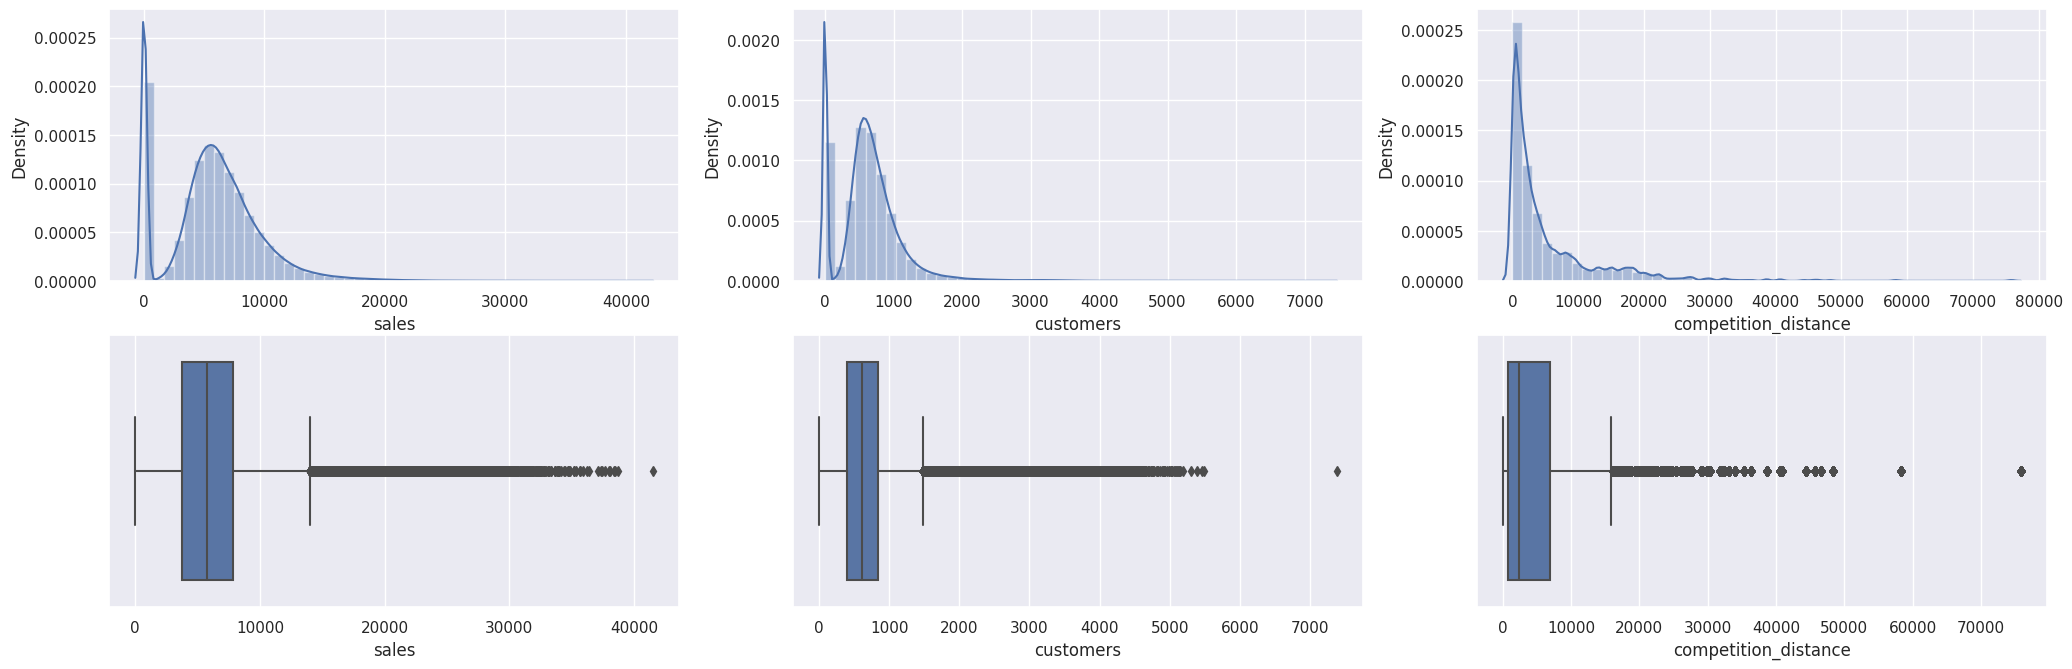

In [37]:
plt.subplot(3, 3, 1)
sns.distplot( df1['sales'] );

plt.subplot(3, 3, 2)
sns.distplot( df1['customers'] );

plt.subplot(3, 3, 3)
sns.distplot( df1['competition_distance'] );

plt.subplot(3, 3, 4)
sns.boxplot(x=df1['sales']);

plt.subplot(3, 3, 5)
sns.boxplot(x=df1['customers']);

plt.subplot(3, 3, 6)
sns.boxplot(x=df1['competition_distance']);


# sns.regplot(x=df1["sales"], y=df1["customers"])

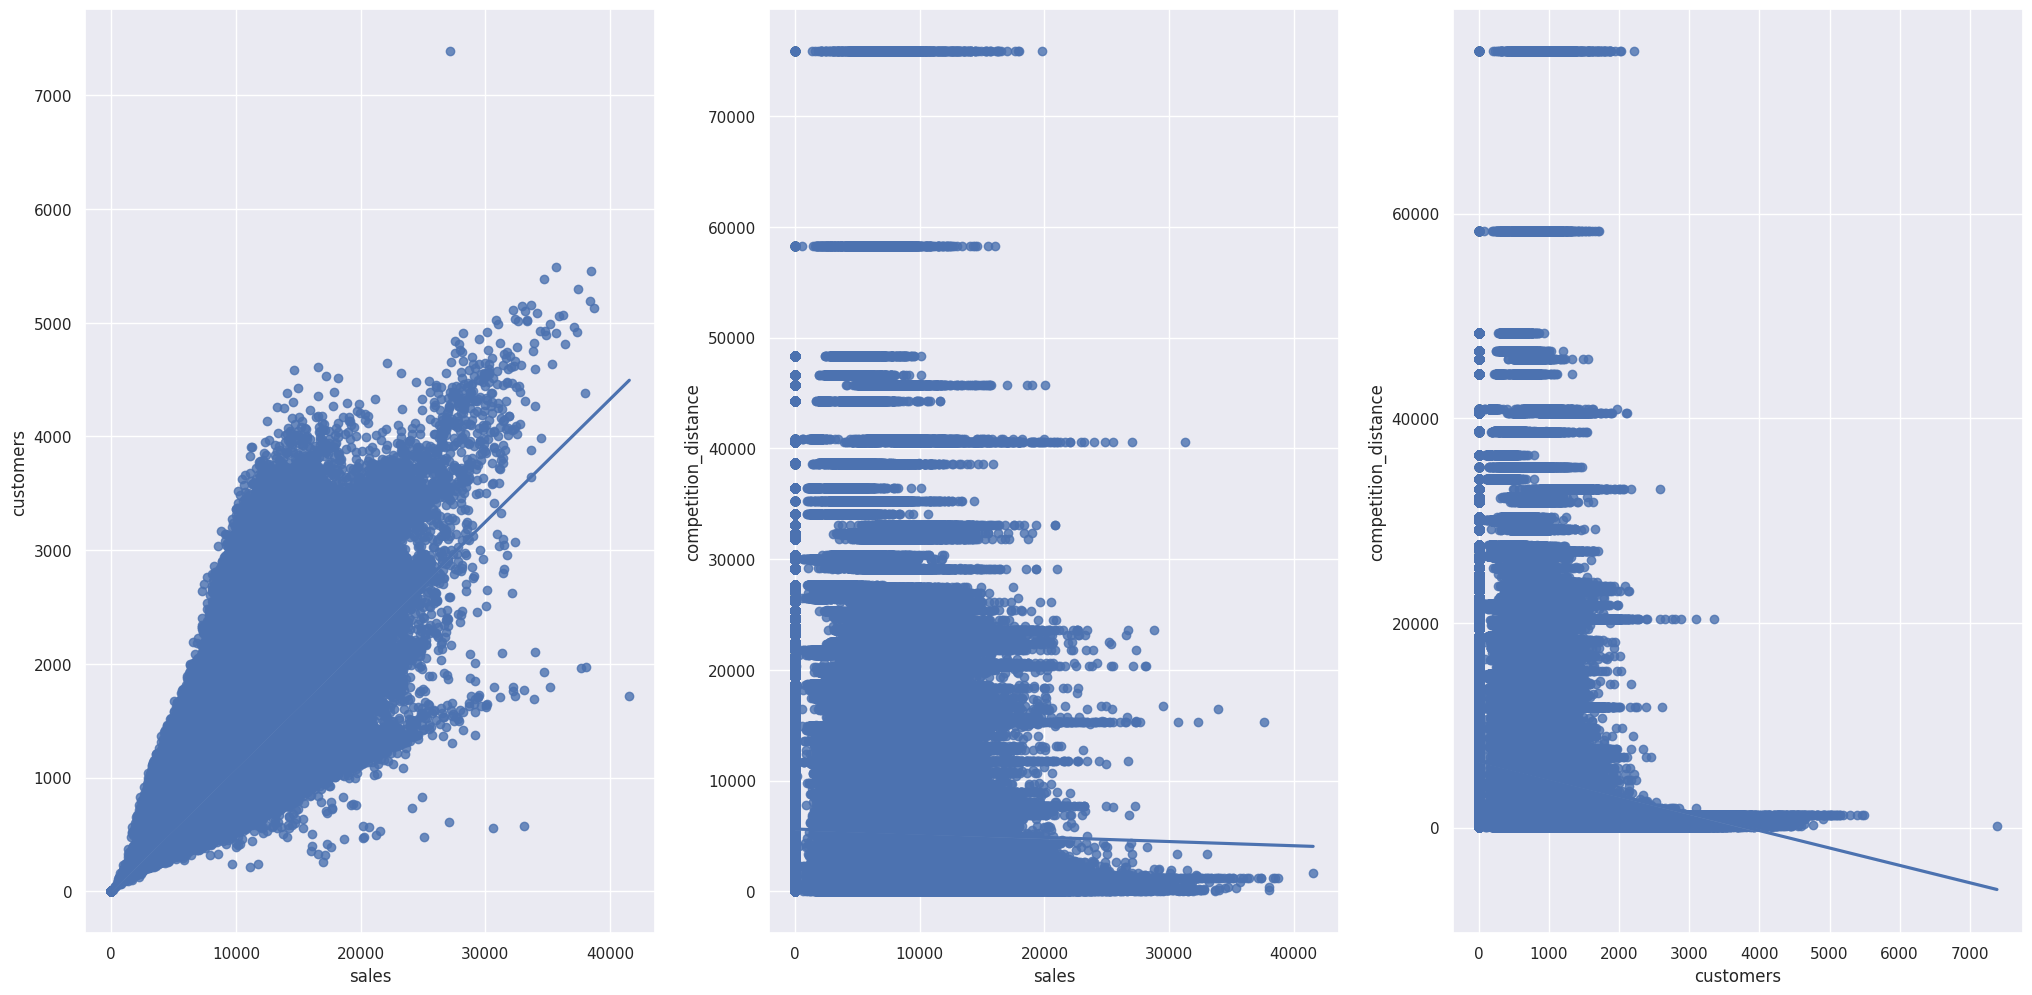

In [39]:
plt.subplot(1, 3, 1)
sns.regplot(x=df1["sales"], y=df1["customers"]);

plt.subplot(1, 3, 2)
sns.regplot(x=df1["sales"], y=df1["competition_distance"]);

plt.subplot(1, 3, 3)
sns.regplot(x=df1["customers"], y=df1["competition_distance"]);

### Atributos Categóricos

In [40]:
cat_attributes.sample(5).T

,737610,505612,998039,328672,329737
store,266,188,900,795,950
day_of_week,7,5,5,3,2
date,2013-09-08 00:00:00,2014-04-04 00:00:00,2013-01-18 00:00:00,2014-09-24 00:00:00,2014-09-23 00:00:00
open,0,1,1,1,1
promo,0,1,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,d,a,d,a
assortment,c,a,a,a,a
competition_open_since_month,3,4,4,9,11


In [41]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

store                           1115
day_of_week                        7
date                             942
open                               2
promo                              2
state_holiday                      4
school_holiday                     2
store_type                         4
assortment                         3
competition_open_since_month      12
competition_open_since_year       23
promo2                             2
promo2_since_week                 52
promo2_since_year                  7
promo_interval                     4
month_map                         12
is_promo                           2
dtype: int64

In [47]:
aux1 = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]

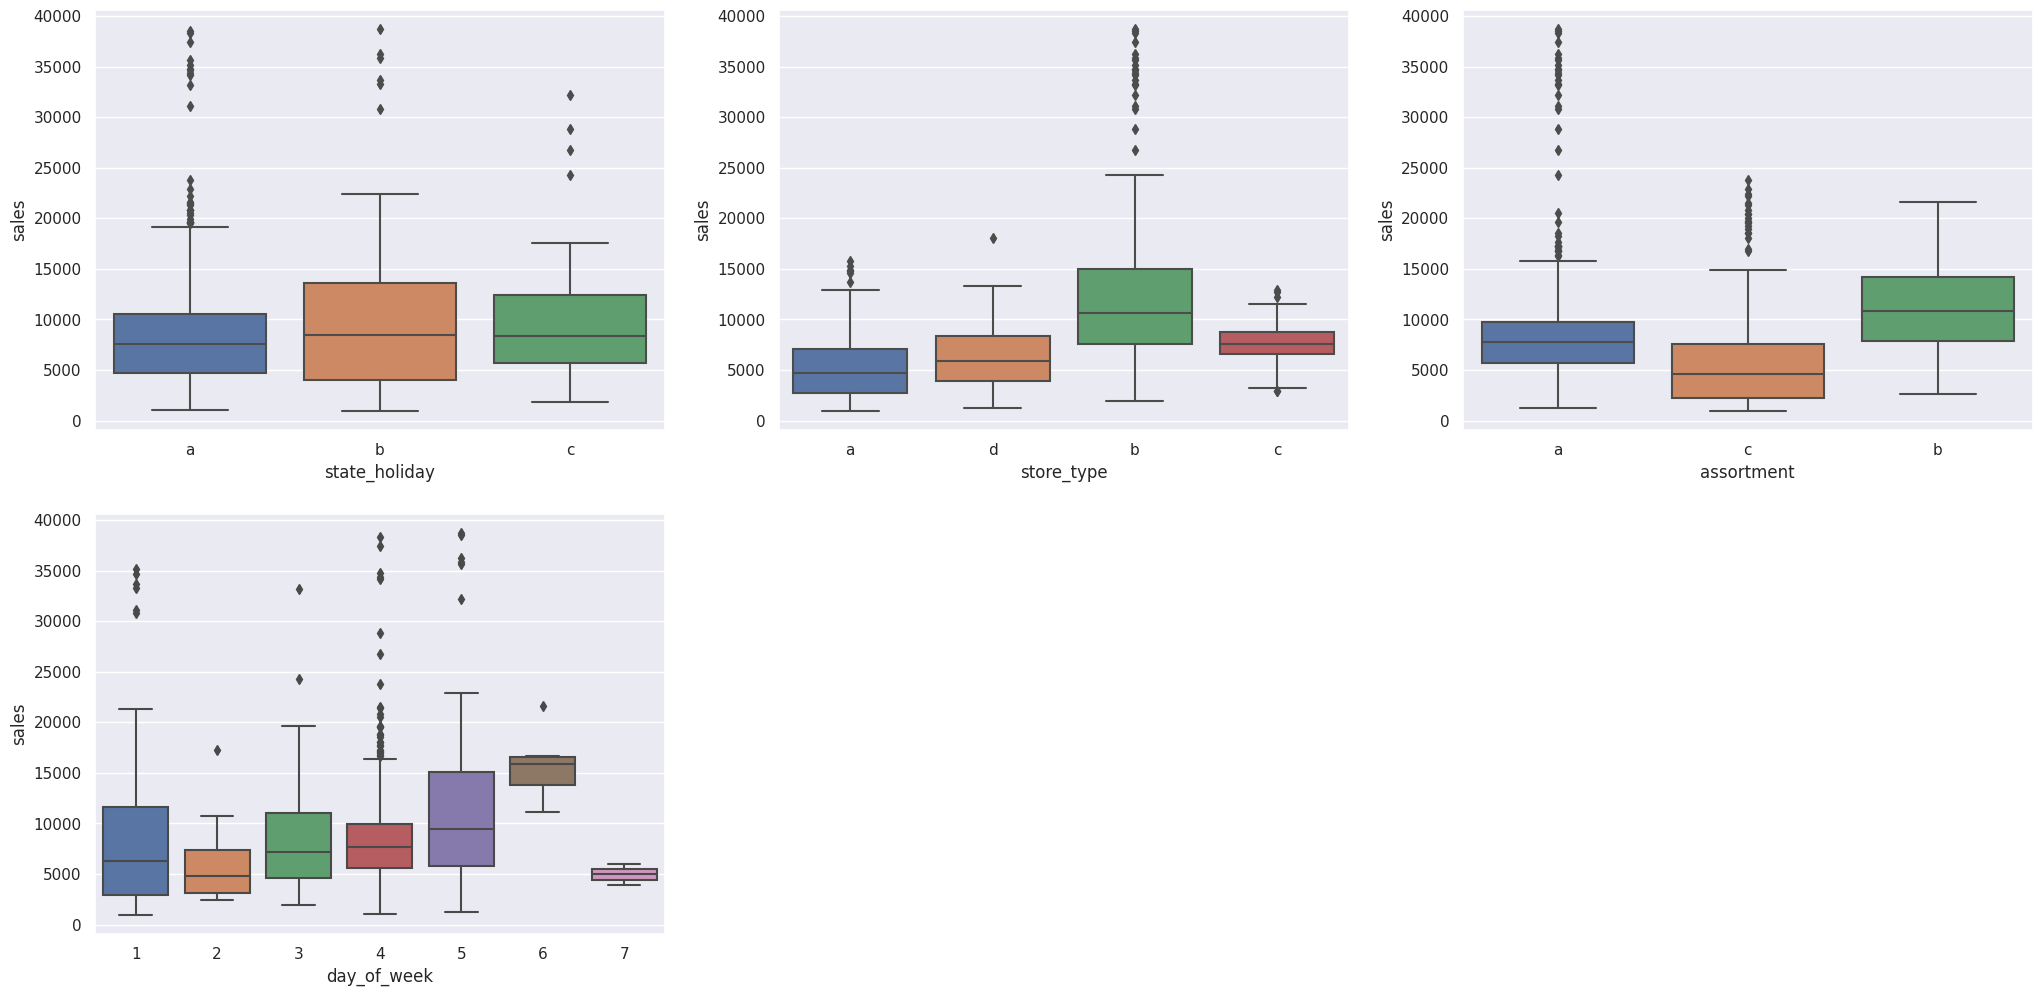

In [52]:
plt.subplot(2,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(2,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1);

plt.subplot(2,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1);

plt.subplot(2,3,4)
sns.boxplot(x='day_of_week', y='sales', data=aux1);

# 2 FEATURA ENGINEERING

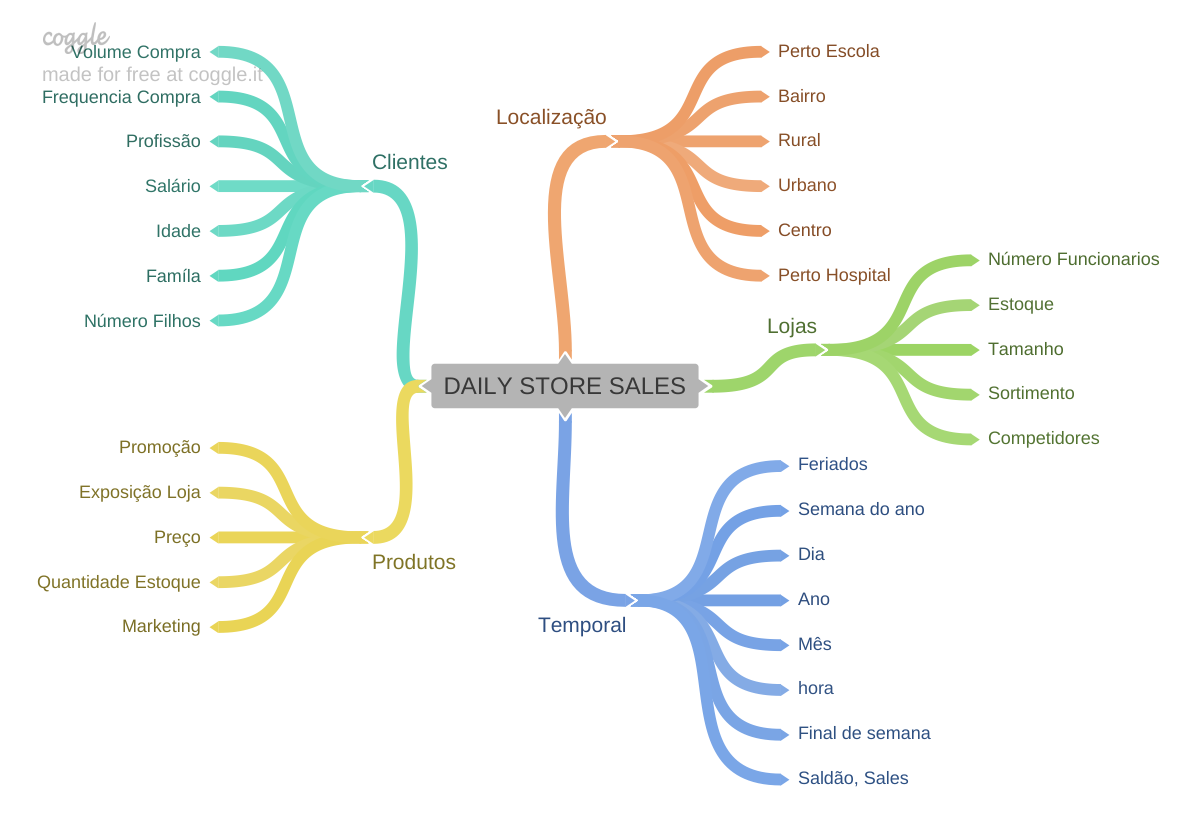

In [62]:
Image('../img/mapa_mental_hipoteses.png')

## Criação das Hipóteses